# Search index

document indexing for advanced search

1. coverting `.docx` to `md`
2. chunking
3. embedding
4. ingesting to **AI Search**

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

## Coverting/Chunking/Embedding

### Coverting using Azure AI Document Intelligence

> You need to provision [Azure Document Intelligence](https://azure.microsoft.com/en-us/products/ai-services/ai-document-intelligence) service before running this notebook

```
pip install azure-ai-documentintelligence==1.0.0b2
```

In [2]:
import os

AZDOCINT_ENDPOINT = os.getenv("AZDOCINT_ENDPOINT")
AZDOCINT_KEY = os.getenv("AZDOCINT_KEY")

In [3]:
import base64

from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.core.credentials import AzureKeyCredential
from azure.ai.documentintelligence.models import AnalyzeResult

document_analysis_client = DocumentIntelligenceClient(
    endpoint=AZDOCINT_ENDPOINT, credential=AzureKeyCredential(AZDOCINT_KEY)
)

### Chunking using LangChain tool

In [4]:
import tiktoken
encoding = tiktoken.get_encoding("cl100k_base")

def token_size(text):
    return len(encoding.encode(text))

> Split MD file based on header `H1`.

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter

def get_encoding_name(model="gpt-3.5-turbo"):
    return tiktoken.encoding_for_model(model).name

headers_to_split_on = [
    ("#", "H1"),
]

markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)

### Embedding

In [6]:
import os
from openai import AzureOpenAI

client = AzureOpenAI(
  api_key = os.environ['JP_AOAI_KEY'],
  api_version = "2024-03-01-preview",
  azure_endpoint = os.environ['JP_AOAI_ENDPOINT']
)

def generate_embeddings(text):
    response = client.embeddings.create(
        input = text,
        model= "text-embedding-ada-002"
    )
    return response.data[0].embedding

> Split document based on `Header` and chunk if the size is greater than 2K with overlap 125.

In [7]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name=get_encoding_name(),
    chunk_size=2000, 
    chunk_overlap=125
)

In [ ]:
# sample `.docx` files
samples = [
    {"file": "sample-khu-policy1.docx", "title": "경희대학교학칙"},
    {"file": "sample-khu-policy2.docx", "title": "위임전결규정"},
]

In [22]:
import pandas as pd
df = pd.DataFrame(columns=['title', 'header', 'chunk', 'parent_id', 'chunk_id', 'vector', 'token_size'])

for i, md in enumerate(samples):
    sample_file = f"./{md['file']}"

    print(f"converting `{sample_file}`...")
    # document intelligence - access files locally
    with open(sample_file, "rb") as f:
        analyze_request = {
            "base64Source": base64.b64encode(f.read()).decode('utf-8')
        }
        poller = document_analysis_client.begin_analyze_document("prebuilt-layout", analyze_request, output_content_format="markdown")

    result = poller.result()
    md_content = result["content"]

    md_file = md['file'].replace(".docx", ".md")

    with open(md_file, "w") as mf:
        mf.write(md_content)

    print(f'saving to `{md_file}` ...')

    print(f"chunking `{sample_file}`...")
    # markdown split
    md_header_splits = markdown_splitter.split_text(md_content)

    # additional text split
    md_text_splits = text_splitter.split_documents(md_header_splits)

    for j, md_split in enumerate(md_text_splits):
        if 'H1' in md_split.metadata:
            if 'H2' in md_split.metadata:
                header = f"{md_split.metadata['H1']}/{md_split.metadata['H2']}"
                chunk = f"## {md_split.metadata['H2']}\n{md_split.page_content}"
            else:
                header = md_split.metadata['H1']
                chunk = f"# {md_split.metadata['H1']}\n{md_split.page_content}"

            new_row = {'title': md['title'], 'header': header,
                       'chunk': chunk, 'parent_id': md['file'], 'chunk_id': f"{j}",
                       'vector': generate_embeddings(chunk), 'token_size': token_size(chunk)}
            df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
        else:
            # title, ignore
            chunk = md_split.page_content

df

converting `./sample-khu-policy1.docx`...
saving to `sample-khu-policy1.md` ...
chunking `./sample-khu-policy1.docx`...
converting `./sample-khu-policy2.docx`...
saving to `sample-khu-policy2.md` ...
chunking `./sample-khu-policy2.docx`...


,title,header,chunk,parent_id,chunk_id,vector,token_size
0,경희대학교학칙,제1장 총칙,"# 제1장 총칙\n## 제1조(목적) \n경희대학교(이하 ""본 대학교""라 한다)는...",sample-khu-policy1.docx,1,"[0.004299728199839592, -0.013456246815621853, ...",1090
1,경희대학교학칙,제2장 대학원,"# 제2장 대학원\n## 제4조(대학원 학칙) \n대학원, 동서의학대학원, 국제대...",sample-khu-policy1.docx,2,"[0.01799730211496353, 0.007478967308998108, 0....",267
2,경희대학교학칙,제3장 부속기관 및 부설연구기관 등,# 제3장 부속기관 및 부설연구기관 등\n## 제5조(부속기관 및 부설연구기관) ...,sample-khu-policy1.docx,3,"[-0.0007064728997647762, 0.008238081820309162,...",725
3,경희대학교학칙,제4장 수업연한과 재학연한,# 제4장 수업연한과 재학연한\n## 제6조(수업연한과 재학연한) \n① 학사과정...,sample-khu-policy1.docx,4,"[-0.009212695062160492, 0.006909521296620369, ...",392
4,경희대학교학칙,"제5장 학년도, 학기, 수업일, 휴업일","# 제5장 학년도, 학기, 수업일, 휴업일\n## 제8조(학년도, 학기) \n① ...",sample-khu-policy1.docx,5,"[-0.0022902791388332844, -0.009431508369743824...",1279
5,경희대학교학칙,"제6장 입학(편입학, 재입학 포함)","# 제6장 입학(편입학, 재입학 포함)\n## 제12조(입학시기) \n입학을 허가...",sample-khu-policy1.docx,6,"[-0.0018715335754677653, 0.007532061543315649,...",1978
6,경희대학교학칙,"제6장 입학(편입학, 재입학 포함)","# 제6장 입학(편입학, 재입학 포함)\n## 제19조의2(입학허가의 취소) \n...",sample-khu-policy1.docx,7,"[-0.002366789849475026, 0.01550485473126173, 0...",408
7,경희대학교학칙,제7장 등록과 수강신청,# 제7장 등록과 수강신청\n## 제21조(등록) \n학생은 매 학기 소정의 기간...,sample-khu-policy1.docx,8,"[0.004599304404109716, -0.012500673532485962, ...",157
8,경희대학교학칙,제8장 전과(부),# 제8장 전과(부)\n## 제23조(전과(부) \n) ① 전과(부)는 입학정원의...,sample-khu-policy1.docx,9,"[0.0030673863366246223, 0.011401932686567307, ...",553
9,경희대학교학칙,제9장 휴학·복학·퇴학·제적,# 제9장 휴학·복학·퇴학·제적\n## 제1절 휴학 및 복학 \n제28조(휴학) ...,sample-khu-policy1.docx,10,"[0.006140707526355982, 0.005347490776330233, 0...",1366


In [9]:
df.to_pickle('aoai-docx-index.pkl')

### Chunk size distribution

In [10]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra

Text(0.5, 1.0, 'Histogram of Data')

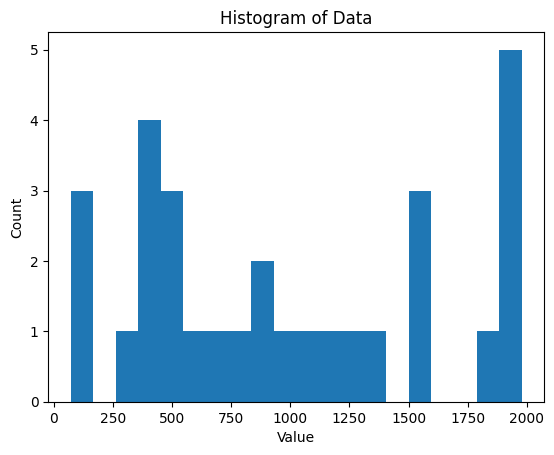

In [11]:
# chatgpt promt: "python code to plot a graph group by count of bin size from data"
data = df['token_size']

bin_size = 100

# Calculate the number of bins based on the bin size
num_bins = int(np.ceil((data.max() - data.min()) / bin_size))

# Create the histogram
plt.hist(data, bins=num_bins)

# Set the axis labels and title
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Histogram of Data')

# Show the plo

## Ingesting

### create a index

In [12]:
from azure.core.credentials import AzureKeyCredential  
from azure.search.documents import SearchClient  
from azure.search.documents.indexes import SearchIndexClient  
from azure.search.documents.indexes.models import (  
    SearchIndex,  
    SearchField,  
    SearchFieldDataType,  
    SimpleField,  
    SearchableField,  
    SearchIndex,  
    SemanticConfiguration,  
    SearchField,  
    VectorSearch,
    SemanticSearch,
    SemanticPrioritizedFields,
    SemanticField,
    HnswAlgorithmConfiguration,
    HnswParameters,
    VectorSearchAlgorithmMetric,
    VectorSearchProfile,
    VectorSearchVectorizer,
    AzureOpenAIVectorizer,
    AzureOpenAIParameters
)

In [13]:
import os
service_endpoint = os.getenv("AZSCH_ENDPOINT")  
key = os.getenv("AZSCH_KEY")  
credential = AzureKeyCredential(key)
index_name = 'aoai-docx-index'

> Config AI search index (fileds, vectorization and semantic rerank)

In [14]:
# Create a search index
index_client = SearchIndexClient( endpoint=service_endpoint, credential=credential)

fields = [
    SimpleField(name="id", type=SearchFieldDataType.String, key=True),
    SearchableField(name="title", type=SearchFieldDataType.String,
                    searchable=True, retrievable=True),
    SearchableField(name="header", type=SearchFieldDataType.String,
                    searchable=True, retrievable=True),
    SearchableField(name="chunk", type=SearchFieldDataType.String,
                    searchable=True, retrievable=True),
    SearchableField(name="parent_id", type=SearchFieldDataType.String,
                    searchable=True, retrievable=True),
    SearchableField(name="chunk_id", type=SearchFieldDataType.String,
                    searchable=True, retrievable=True),
    SearchField(name="vector", type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
                searchable=True, vector_search_dimensions=1536, vector_search_profile_name="myHnswProfile")  
]

vector_search = VectorSearch(  
    algorithms=[  
        HnswAlgorithmConfiguration(  
            name="myHnsw",  
            parameters=HnswParameters(  
                m=4,  
                ef_construction=400,  
                ef_search=500,  
                metric=VectorSearchAlgorithmMetric.COSINE,  
            ),  
        )
    ],  
    profiles=[  
        VectorSearchProfile(  
            name="myHnswProfile",  
            algorithm_configuration_name="myHnsw",
            vectorizer="aoai-table-vectorizer"
        ),
    ],
    vectorizers=[
        AzureOpenAIVectorizer(
            name="aoai-table-vectorizer",
            azure_open_ai_parameters = AzureOpenAIParameters(
                resource_uri = os.getenv('JP_AOAI_ENDPOINT'),
                deployment_id = "text-embedding-ada-002",
                api_key = os.getenv("JP_AOAI_KEY")
            )
        )
    ]
)  

semantic_search = SemanticSearch(
    configurations = [SemanticConfiguration(
        name="semantic-config",
        prioritized_fields=SemanticPrioritizedFields(
            title_field=SemanticField(
                field_name="title"
            ),
            content_fields=[SemanticField(
                field_name="chunk"
            )],
            keywords_fields=[]
        )
    )]
)

# Create the search index
index = SearchIndex(name=index_name, fields=fields,
                    vector_search=vector_search, semantic_search=semantic_search)
result = index_client.create_or_update_index(index)
print(f' {result.name} created')

 aoai-docx-index created


### upload data

In [15]:
search_client = SearchClient(endpoint=service_endpoint, index_name=index_name, credential=credential)

In [16]:
import json
from tqdm.auto import tqdm

count = 0
batch_size = 20
for i in tqdm(range(0, len(df), batch_size)):
    # set end position of batch
    i_end = min(i+batch_size, len(df))
    
    documents = df[i:i_end].apply(
        lambda row: {'id': str(row.name), 
                     'title': row['title'], 
                     'header': row['header'],
                     'chunk': row['chunk'],
                     'parent_id': row['parent_id'],
                     'chunk_id': str(row['chunk_id']),
                     #'vector': generate_embeddings(row['chunk'])
                     'vector': row['vector']
                    }, axis=1).to_list()
    
    result = search_client.upload_documents(documents)  

c:\Users\ilkim\AppData\Local\miniconda3\envs\pf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


### Retrieve test

In [19]:
#search_client = SearchClient(endpoint=service_endpoint, index_name=index_name, credential=credential)

In [17]:
from azure.search.documents.models import VectorizableTextQuery, VectorQuery, VectorizedQuery
from azure.search.documents.models import (
    QueryType,
    QueryCaptionType,
    QueryAnswerType
)

In [18]:
def get_results(text):
    vector_query = VectorizableTextQuery(text=text, k_nearest_neighbors=3, fields="vector", exhaustive=True)
    results = search_client.search(  
        search_text=None,  
        vector_queries= [vector_query],
        select=["parent_id", "chunk_id", "chunk", "title"],
        top=3
    )

    return results

In [19]:
from colorama import Fore, Back, Style

def azsch_embed_query(query):
    #vector_query = VectorizedQuery(vector=generate_embeddings(query), k_nearest_neighbors=3, fields="vector")
    vector_query = VectorizableTextQuery(text=query, k_nearest_neighbors=3, fields="vector", exhaustive=True)

    results = search_client.search(  
        search_text=None,  
        vector_queries=[vector_query],
        select=["title", "chunk", "parent_id", "chunk_id"],
        top=3 # for limiting text search
    ) 

    for result in results:  
        print((Fore.RED if (result['@search.score'] < 0.8) else Fore.GREEN) + f"{result['@search.score']:.10f}" 
              + Style.RESET_ALL + f": {result['title']} - {result['parent_id']}, {result['chunk_id']}") 
        
    return results

In [20]:
results = azsch_embed_query('업무 규정 중 자비 해외 출장의 전결권자는?')

0.8499734400: 위임전결규정 - sample-khu-policy2.docx, 1
0.8485768400: 위임전결규정 - sample-khu-policy2.docx, 2
0.8365778000: 경희대학교학칙 - sample-khu-policy1.docx, 10


In [21]:
results = azsch_embed_query('자비 해외 출장 전결권자')

0.8335399600: 위임전결규정 - sample-khu-policy2.docx, 2
0.8301927400: 경희대학교학칙 - sample-khu-policy1.docx, 10
0.8284812600: 위임전결규정 - sample-khu-policy2.docx, 1


### Semantic Rerank

In [25]:
def azsch_semantic_query(query):
    #vector_query = VectorizedQuery(vector=generate_embeddings(query), k_nearest_neighbors=3, fields="vector")
    vector_query = VectorizableTextQuery(text=query, k_nearest_neighbors=3, fields="vector", exhaustive=True)

    results = search_client.search(  
        search_text=query,
        vector_queries=[vector_query],
        select=["parent_id", "chunk_id", "chunk", "title"],
        query_type=QueryType.SEMANTIC,
        semantic_configuration_name='semantic-config',
        top=3
    ) 

    for result in results:  
        print(f"{Fore.GREEN} {result['@search.reranker_score']:.10f}" 
              + Style.RESET_ALL + f": {result['title']} - {result['parent_id']}, {result['chunk_id']}") 
    return results

In [26]:
results = azsch_semantic_query('업무 규정 중 자비 해외 출장의 전결권자는?')

 2.2333793640: 위임전결규정 - sample-khu-policy2.docx, 1
 1.2388173342: 위임전결규정 - sample-khu-policy2.docx, 2
 0.9546567798: 경희대학교학칙 - sample-khu-policy1.docx, 20


In [27]:
results = azsch_semantic_query('자비 해외 출장 전결권자')

 1.8872740269: 위임전결규정 - sample-khu-policy2.docx, 1
 0.9194239378: 위임전결규정 - sample-khu-policy2.docx, 2
 0.3572303355: 경희대학교학칙 - sample-khu-policy1.docx, 10


In [28]:
def azsch_text_query(query):
    # Text Search
    results = search_client.search(  
        search_text=query,  
        vector_queries=None,
        select=["parent_id", "chunk_id", "chunk", "title"],
        top=3
    )  
    
    for result in results:  
        print(f"{Fore.GREEN} {result['@search.score']}"
            + Style.RESET_ALL + f": {result['title']} - {result['parent_id']}, {result['chunk_id']}") 
        #print(f"Content: {result['chunk']}")

    return results

In [29]:
results = azsch_text_query('업무 규정 중 자비 해외 출장의 전결권자는?')

 2.4520986: 위임전결규정 - sample-khu-policy2.docx, 2
 2.0628278: 경희대학교학칙 - sample-khu-policy1.docx, 13
 1.4823178: 경희대학교학칙 - sample-khu-policy1.docx, 24


In [30]:
results = azsch_text_query('자비 해외 출장 전결권자')

 2.162065: 위임전결규정 - sample-khu-policy2.docx, 2
 0.8095889: 위임전결규정 - sample-khu-policy2.docx, 1
